In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib widget

import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
import csv
from skimage.measure import marching_cubes
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from os.path import split,join,splitext

import pandas as pd
from scipy.stats import multivariate_normal
import os

In [2]:
ontology_name = '/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'

### Load UPenn ontology + Generate lists of descendents

In [3]:
xS,S,_,_ = emlddmm.read_data(seg_name)

In [4]:
# Transforms xS into a set of coordinates
XS = np.stack(np.meshgrid(*xS,indexing='ij'),-1)

In [5]:
# Center of mass of region 2294 (Definition of the 1st moment of the indicator function for label 2294)
# np.sum(XS*(S[0,...,None]==2294))/np.sum(S==2294)

In [6]:
parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1


['\ufeffid', 'name', 'acronym', 'red', 'green', 'blue', 'structure_order', 'parent_id', 'parent_acronym']


In [7]:
# we need to find all the descendants of a given label
# first we'll get children
children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

In [8]:
# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

In [9]:
descendents_and_self = dict(descendents)
for o in ontology:
    if o not in descendents_and_self:
        descendents_and_self[o] = [o]
    else:
        descendents_and_self[o].append(o)

In [10]:
ontology

{0: ('background', 'background', -1),
 997: ('root', 'root', -1),
 8: ('grey', 'Basic cell groups and regions', 997),
 567: ('CH', 'Cerebrum', 8),
 688: ('CTX', 'Cerebral cortex', 567),
 695: ('CTXpl', 'Cortical plate', 688),
 315: ('Isocortex', 'Isocortex', 695),
 184: ('FrA', 'Frontal association cortex', 315),
 68: ('FrA-1', 'Frontal pole, layer 1', 184),
 667: ('FrA-2/3', 'Frontal pole, layer 2/3', 184),
 2325: ('FrA-5', 'Frontal pole, layer 5', 184),
 500: ('M', 'motor cortex', 315),
 985: ('M1', 'Primary motor cortex', 500),
 320: ('M1-1', 'Primary motor cortex, layer 1', 985),
 943: ('M1-2/3', 'Primary motor cortex, layer 2/3', 985),
 648: ('M1-5', 'Primary motor cortex, layer 5', 985),
 844: ('M1-6a', 'Primary motor cortex, layer 6a', 985),
 882: ('M1-6b', 'Primary motor cortex, layer 6b', 985),
 2017: ('FrC3', 'Frontal cortex, area 3', 985),
 2334: ('FrC3-1', 'Frontal cortex, area 3, layer1', 2017),
 2335: ('FrC3-2/3', 'Frontal cortex, area 3, layer2/3', 2017),
 2336: ('FrC3-5

## Generate Boolean masks for CP, CPr (+CPre), CPi, CPc (+CPce)

In [11]:
# find all the descendents of Caudoputemen- rostral
# and caudoputemen rostral- extreme

In [12]:
# these are all the structures in the CP
cp = list(descendents_and_self[672])
Scp = np.zeros_like(S)
for l in cp:
    Scp = np.logical_or(Scp,S==l)

In [13]:
# these are the structures one level below CP, with extreme's merged in
rostral = list(descendents_and_self[2376]) # rostral extreme
rostral.extend(list(descendents_and_self[2491])) # rostral 
rostral = list(dict.fromkeys(rostral))

intermediate = list(descendents_and_self[2492]) # intermediate

caudal = list(descendents_and_self[2496]) # caudal
caudal_ = list(descendents_and_self[2495]) # caudal extreme
caudal.extend(caudal_)

In [14]:
Srostral = np.zeros_like(S)
for l in rostral:
    Srostral = np.logical_or(Srostral, S==l)

In [15]:
Sintermediate = np.zeros_like(S)
for l in intermediate:
    Sintermediate = np.logical_or(Sintermediate, S==l)

In [16]:
Scaudal = np.zeros_like(S)
for l in caudal:
    Scaudal = np.logical_or(Scaudal, S==l)

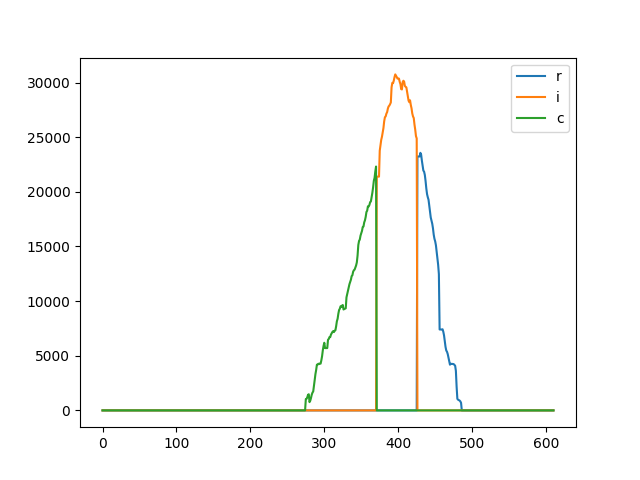

In [17]:
fig,ax = plt.subplots()
ax.plot(np.sum(Srostral>0,axis=(0,2,3)),label='r')
ax.plot(np.sum(Sintermediate>0,axis=(0,2,3)),label='i')
ax.plot(np.sum(Scaudal>0,axis=(0,2,3)),label='c')
ax.legend()

In [18]:
# TODO
# add one more level down the tree

def generate_region_mask(S, regionID):
    self_and_children = list(descendents_and_self[regionID])
    region_mask = np.zeros_like(S)
    for i in self_and_children:
        region_mask = np.logical_or(region_mask, S==i)
    return region_mask

Scpr_m   = generate_region_mask(S,2294)
Scpr_imd = generate_region_mask(S,2295)
Scpr_imv = generate_region_mask(S,2296)
Scpr_l   = generate_region_mask(S,2497)
Scpi_dm  = generate_region_mask(S,2498)
Scpi_vm  = generate_region_mask(S,2500)
Scpi_dl  = generate_region_mask(S,2499)
Scpi_vl  = generate_region_mask(S,2501)
Scpc_d   = generate_region_mask(S,2493)
Scpc_i   = generate_region_mask(S,2494)
Scpc_v   = generate_region_mask(S,2490)

In [19]:
print(f'N (Scp): {np.sum(Scp):,}')
print(f'N (Scpr): {np.sum(Srostral):,}')
print(f'N (Scpi): {np.sum(Sintermediate):,}')
print(f'N (Scpc): {np.sum(Scaudal):,}')

print(f'N (Scpr_m): {np.sum(Scpr_m):,}')
print(f'N (Scpr_imd): {np.sum(Scpr_imd):,}')
print(f'N (Scpr_imv): {np.sum(Scpr_imv):,}')
print(f'N (Scpr_l): {np.sum(Scpr_l):,}')

print(f'N (Scpi_dm): {np.sum(Scpi_dm):,}')
print(f'N (Scpi_vm): {np.sum(Scpi_vm):,}')
print(f'N (Scpi_dl): {np.sum(Scpi_dl):,}')
print(f'N (Scpi_vl): {np.sum(Scpi_vl):,}')

print(f'N (Scpc_d): {np.sum(Scpc_d):,}')
print(f'N (Scpc_i): {np.sum(Scpc_i):,}')
print(f'N (Scpc_v): {np.sum(Scpc_v):,}')

N (Scp): 3,229,761
N (Scpr): 706,051
N (Scpi): 1,520,835
N (Scpc): 958,160
N (Scpr_m): 70,819
N (Scpr_imd): 99,533
N (Scpr_imv): 111,221
N (Scpr_l): 291,109
N (Scpi_dm): 421,650
N (Scpi_vm): 225,215
N (Scpi_dl): 255,682
N (Scpi_vl): 618,288
N (Scpc_d): 256,855
N (Scpc_i): 425,212
N (Scpc_v): 197,721


In [20]:
# I think what I'd like to do is assign a gaussian to each region
# then give the neurons a distribution based on the Gaussian
# to do this I should load a set of neurons
# and also start visualizing

# what I think would make sense is to take all the cp structures
# blur them a lot
# then assign probabilities
# we also want to look at the neurons though

In [21]:
# i want to start by visualizing
# we need to load swc files
# and we need to contour the surfaces
d = [x[1] - x[0] for x in xS]


In [22]:
down = 16
xSd,Scpd = emlddmm.downmode(xS,Scp[0],down=[down,down,down])

/home/dtward/data/csh_data/emlddmm/emlddmm.py:620: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  S_ = mode(S_,axis=0)[0][0]


In [23]:
dd = [x[1] - x[0] for x in xSd]

In [24]:
verts,faces,normals,values = marching_cubes(Scpd,level=0.5,spacing=dd)
verts = verts + np.array([x[0] for x in xSd])

## Load SWC files and Display 2x2 figure

In [25]:
# swcdir = '../swc_out_v08' # this is tme07
# swcdir = '../dragonfly_tme09-1/swc_out_v08'
# swcdir = '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs'

brain = 'TME08-1'
swcdir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs'
files = glob(join(swcdir,'*.swc'))
files = [f for f in files if 'permuted' not in f]
files

['/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/126_TME08-1_30x_Str_03B_x10703_y19209_z262_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/196_TME08-1_30x_Str_05A_x4192_y8886_z266_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/070_TME08-1_30x_Str_03A_x10604_y9246_z388_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/089_TME08-1_30x_Str_03A_x13329_y15236_z146_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/124_TME08-1_30x_Str_03B_x10385_y16980_z320_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/177_TME08-1_30x_Str_04B_x2128_y17866_z324_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/115_TME08-1_30x_Str_03A_x904

In [26]:
x = []
for file in files:
    with open(file)  as f:
        for i,line in enumerate(f):    
            print(line)
            if 'Tward' in line:                
                continue
            else:
                if ',' in line:
                    lim = ','
                else:
                    lim = ''
                coords = [float(c) for c in line.split(lim)[2:5]]                
                    
                x.append(coords)
                break
    
            
x = np.array(x)            
            

1,2295,1987.2894287109375,-2238.781005859375,-735.301513671875,1.0,-1

1,2482,1099.238037109375,3087.34521484375,417.36419677734375,1.0,-1

1,2297,2357.436279296875,2096.536865234375,1392.9444580078125,1.0,-1

1,2374,1867.044677734375,1400.3619384765625,66.26272583007812,1.0,-1

1,2395,2050.076416015625,-2173.67529296875,-281.76873779296875,1.0,-1

1,2298,1361.1986083984375,1420.592041015625,90.6671371459961,1.0,-1

1,2395,2118.170654296875,2247.26416015625,123.59200286865234,1.0,-1

1,2295,2174.11669921875,-1531.683349609375,-359.755126953125,1.0,-1

1,2295,2573.8671875,1635.5091552734375,-209.328369140625,1.0,-1

1,2479,1256.53564453125,2657.447021484375,-57.729122161865234,1.0,-1

1,2297,2382.3447265625,-2213.146728515625,1534.0667724609375,1.0,-1

1,2490,570.3156127929688,2907.587158203125,1541.150634765625,1.0,-1

1,2343,2321.042236328125,-2575.27099609375,-992.607666015625,1.0,-1

1,2380,1428.3345947265625,-1443.557373046875,-1016.670654296875,1.0,-1

1,2068,-509.56512451171875,3

### Generate + Save figure

Text(0.5, 0.98, 'TME08-1')

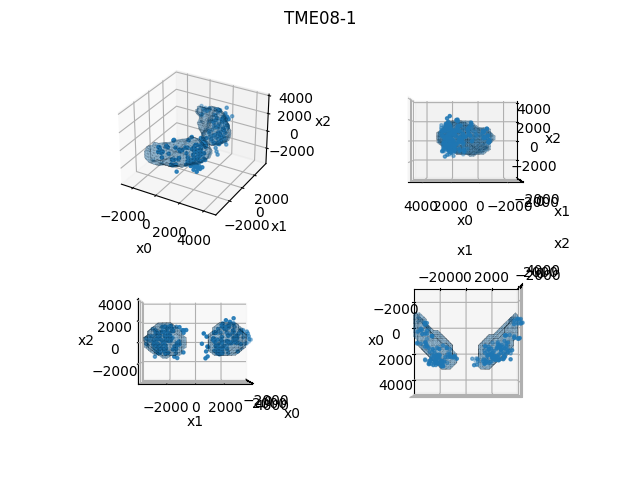

In [27]:
s = 5
alpha = 0.25
lw = 0.25


mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)


ax = fig.add_subplot(2,2,2,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(0,90)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)



ax = fig.add_subplot(2,2,3,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(0,0)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)



ax = fig.add_subplot(2,2,4,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(90,0)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)

# fig.suptitle(swcdir.split('/')[-2])
# fig.savefig('CP_SWC_QC_figure_'+swcdir.split('/')[-2]+'.jpg')

fig.suptitle(f'{brain}')
# fig.savefig(join(f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/',f'CP_SWC_QC_figure_{brain}.jpg'))

In [28]:
# raise Exception(f'End of QC figure generation for {brain}')

In [29]:
# so what is a plan going forward
# I'd like to take every blob as a gaussian
# the height is its volume
# the mean is its mean
# the covariance is its covariance
# the only trouble here is the left right issue
# another posiblility is to just blur the labels
# this may get rid of small structures though
# but I could give less blur to the small structures

In [30]:
# first going forward
# 1. make a figure like this to get a sense of the uncertainty for each brain
# 2. make a probabilitistic version of the CP structures.
# I'd like to model each structure as a gaussian blob (ellispoids with soft boundaries)
# this needs three parameters
# the mean (a 3 element vector)
# the covariance (3x3 symmetric matrix)
# and the height/amplitude of the gaussian (one positive number)

# The height (amplitude) should be the number of voxels in the structure
# the mean, is going to be the first moment of the segmentation
# the covariance, is the second central moment of the segmentation.

### Compute + Save Gaussian parameters for CP

In [31]:
def generate_gaussian_param(subregion_mask, hemi, fname):
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere
    
    # ===== Compute Gaussian parameters =====
    
    # number of voxels in 'subregion'
    Ncp = np.sum(subregion_mask*LR_indicator)
    print(f'number of voxels {Ncp}')
    
    # note xS tells us the location of each voxel
    # let's compute the first moment
    mucp = [np.sum(xS[0][:,None,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[1][:,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[2][:]*subregion_mask*LR_indicator)/Ncp]
    print(f'mu {mucp}')
    
    # now calculate the covariance matrix
    covcp01 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[1][:,None] - mucp[1])*subregion_mask*LR_indicator)/Ncp # here row 0 column 1
    covcp02 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 0 column 2
    covcp12 = np.sum((xS[1][None,:,None] - mucp[1])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 1 column 2
    
    covcp00 = np.sum(((xS[0][:,None,None] - mucp[0])**2)*subregion_mask*LR_indicator)/Ncp # here row 0 column 0
    covcp11 = np.sum(((xS[1][None,:,None] - mucp[1])**2)*subregion_mask*LR_indicator)/Ncp # here row 1 column 1
    covcp22 = np.sum(((xS[2][None,None,:] - mucp[2])**2)*subregion_mask*LR_indicator)/Ncp # here row 2 column 2
    
    covcp = [[covcp00,covcp01,covcp02],[covcp01,covcp11,covcp12],[covcp02,covcp12,covcp22]]
    
    print('cov:')
    print(f'{covcp[0]}')
    print(f'{covcp[1]}')
    print(f'{covcp[2]}')
    
    # Save Gaussian parameters in.npz file with keys [height, mu, cov]
    save_path = join('/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
    np.savez(save_path,height=[Ncp],mu=mucp,cov=covcp)
    print(f'Saved {fname}\n')

# ===== Specify subregion and hemisphere =====
genParam = False
if genParam:
    for hemi in ['L','R']:
        generate_gaussian_param(Scp, hemi,f'cp_param_{hemi}.npz')
        generate_gaussian_param(Srostral, hemi,f'cpr_param_{hemi}.npz')
        generate_gaussian_param(Sintermediate, hemi,f'cpi_param_{hemi}.npz')
        generate_gaussian_param(Scaudal, hemi,f'cpc_param_{hemi}.npz')
        
        generate_gaussian_param(Scpr_m, hemi,f'cpr_m_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imd, hemi,f'cpr_imd_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imv, hemi,f'cpr_imv_param_{hemi}.npz')
        generate_gaussian_param(Scpr_l, hemi,f'cpr_l_param_{hemi}.npz')
        
        generate_gaussian_param(Scpi_dm, hemi,f'cpi_dm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vm, hemi,f'cpi_vm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_dl, hemi,f'cpi_dl_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vl, hemi,f'cpi_vl_param_{hemi}.npz')
        
        generate_gaussian_param(Scpc_d, hemi,f'cpc_d_param_{hemi}.npz')
        generate_gaussian_param(Scpc_i, hemi,f'cpc_i_param_{hemi}.npz')
        generate_gaussian_param(Scpc_v, hemi,f'cpc_v_param_{hemi}.npz')

### Load Gaussian parameters given hemi and subregion

In [32]:
# hemi = 'L'
hemi = 'R'
subregion = ''

fname = f'cpc_v_param_{hemi}.npz'
fpath = join(f'/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
out = np.load(fpath)

h = out['height'][0]
mu = out['mu']
cov = out['cov']

print(f'Displating parameters for {fname};\n')
print(f'height: {h}')
print(f'mu: {mu}')
print(f'cov: {cov}')

Displating parameters for cpc_v_param_R.npz;

height: 98845
mu: [ 394.72375942 3143.2739137  1075.84389701]
cov: [[123992.11677122 -29055.38829264  19248.51805967]
 [-29055.38829264  79812.81631632 -31988.42170582]
 [ 19248.51805967 -31988.42170582  75230.84760312]]


In [33]:
# once we have parameters for each gaussian
# then we can evalute them at every point in space
# so for a given cell body, we can find a distribution over this number of regions
# for each level of the tree, you can get a distribution over all the structures in that level
# start with R-I-C level
# TODO, come up with some measure of concordance
#   that is related to nick's labels, but allows some slop

In [34]:
# we don't really believe the uncertaint is given by the voxel size (we're not getting 1 voxel accurate registration)
# we believe it is related to the anatomy

### Compute distance transform for each mask

In [70]:
from scipy.ndimage import distance_transform_edt
import time

def generateDistanceTransform(xS, mask, hemi, fname, scale_factor = 200):
    start = time.time()
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere

    transformedMask = np.exp(-distance_transform_edt(mask*LR_indicator)/scale_factor)
    transformedMask[transformedMask == 1.0] = 0.0
    transformedMask = transformedMask / np.sum(transformedMask)
    
    # Save distance transform parameters in .npz file with keys [mask]
    save_path = join('/home/abenneck/dragonfly_work/distance_parameters/',fname)
    np.savez(save_path, mask = transformedMask)
    print(f'Saved {fname} after {time.time() - start : .2f} s')
    
    return transformedMask

saveDistanceParam = True
if saveDistanceParam:
    for hemi in ['L', 'R']:
        generateDistanceTransform(xS, Scp, hemi, f'cp_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Srostral, hemi, f'cpr_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Sintermediate, hemi, f'cpi_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scaudal, hemi, f'cpc_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpr_m, hemi, f'cpr_m_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imd, hemi, f'cpr_imd_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imv, hemi, f'cpr_imv_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_l, hemi, f'cpr_l_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpi_dm, hemi, f'cpi_dm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vm, hemi, f'cpi_vm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_dl, hemi, f'cpi_dl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vl, hemi, f'cpi_vl_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpc_d, hemi, f'cpc_d_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_i, hemi, f'cpc_i_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_v, hemi, f'cpc_v_dist_param_{hemi}.npz')

Saved cp_dist_param_L.npz after  72.94 s
Saved cpr_dist_param_L.npz after  70.87 s
Saved cpi_dist_param_L.npz after  75.32 s
Saved cpc_dist_param_L.npz after  70.23 s
Saved cpr_m_dist_param_L.npz after  71.48 s
Saved cpr_imd_dist_param_L.npz after  72.25 s
Saved cpr_imv_dist_param_L.npz after  72.44 s
Saved cpr_l_dist_param_L.npz after  72.26 s
Saved cpi_dm_dist_param_L.npz after  72.22 s
Saved cpi_vm_dist_param_L.npz after  71.74 s
Saved cpi_dl_dist_param_L.npz after  70.76 s
Saved cpi_vl_dist_param_L.npz after  70.09 s
Saved cpc_d_dist_param_L.npz after  71.91 s
Saved cpc_i_dist_param_L.npz after  70.72 s
Saved cpc_v_dist_param_L.npz after  71.68 s
Saved cp_dist_param_R.npz after  72.86 s
Saved cpr_dist_param_R.npz after  69.92 s
Saved cpi_dist_param_R.npz after  72.08 s
Saved cpc_dist_param_R.npz after  70.13 s
Saved cpr_m_dist_param_R.npz after  70.09 s
Saved cpr_imd_dist_param_R.npz after  72.53 s
Saved cpr_imv_dist_param_R.npz after  71.50 s
Saved cpr_l_dist_param_R.npz after  72

### Load dist param

In [37]:
out = np.load('/home/abenneck/dragonfly_work/distance_parameters/cp_dist_param_L.npz')
out = out['mask']

x, y, z = 100, 100, -100

print(out[0, x, y, z])

8.55590144118812e-09


In [38]:
def L1_filter_gauss(fileName):
    if len(fileName) <= 15 and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def L2_filter_gauss(fileName):
    if len(fileName) > 15 and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def L1_filter_dist(fileName):
    if len(fileName) <= 21 and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def L2_filter_dist(fileName):
    if len(fileName) > 21 and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def get_coord_list(region_id, XS, S):
    self_and_children = list(descendents_and_self[region_id])
    allCoords = list()
    for idNum in self_and_children:
        regionCoords = XS[S[0]==idNum]
        if regionCoords != []:
            for coord in regionCoords:
                out = [coord[2], coord[1], coord[0]] # Reorganize axes to align with .swc format
                allCoords.append(out)
    return allCoords

# Distance with vectorization
def dist_from_cp(allCoords, soma_location, useForLoop = False):
    if useForLoop:
        minDist = -1
        for c in allCoords:
            distance = math.dist(c,soma_location)
            if minDist == -1 or minDist > distance:
                minDist = distance
        return minDist        
    else:
        # out = allCoords-soma_location => [allCoords[0]-soma_location, allCoords[1]-soma_location, ...]
        # out = (out)**2                => Square all terms within out
        # out = np.sum(out, axis=1)     => [out[0][0]+out[0][1]+out[0][2], out[1][0]+out[1][1]+out[1][2], ...]
        # out = np.sqrt(out)            => sqrt all terms within out
        # out = np.min(out)             => min of all distances
        return np.min(np.sqrt(np.sum((allCoords-soma_location)**2, axis=1)))

# Round neuron coord to nearest atlas coord
def roundCoord(sub_xS, coord):
    if coord < np.min(sub_xS):
        coord = np.min(sub_xS)
    elif coord > np.max(sub_xS):
        coord = np.max(sub_xS)
    else:
        coord_rounded = 20*round(coord/20) # Round coordinate to nearest 20
        if coord < 0:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
        else:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
    return coord

In [43]:
hemi = 'R'

if hemi == 'R':
    LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
else:
    LR_indicator = (xS[1][:,None]<0)  # Left hemisphere

# Define idx and coord values for the CP (For debugging purposes)
cp_idx_x = np.unique(np.where(Scp[0] == 1)[0])
cp_coords_x = xS[0][cp_idx_x]

cp_idx_y = np.unique(np.where(Scp[0]*LR_indicator == 1)[1])
cp_coords_y = xS[1][cp_idx_y]
# print(cp_coords_y)

cp_idx_z = np.unique(np.where(Scp[0] == 1)[2])
cp_coords_z = xS[2][cp_idx_z]

In [81]:
# brains = ['TME07-1', 'TME08-1', 'TME09-1', 'TME10-1', 'TME10-3', 'TME12-1']
brains = ['TME09-1']

# allRegionCoords = get_coord_list(672, XS, S) # 672 is regionID for CP
# allRegionCoords = np.asarray(allRegionCoords)
# uniform_prior = 1/6

# print('Loading regional amplitudes')
# start = time.time()
# # Create list of priors from presaved parameters
# paramDir = '/home/abenneck/dragonfly_work/gaussian_parameters'
# L1_files = sorted(filter(L1_filter_gauss,os.listdir(paramDir)))
# L2_files = sorted(filter(L2_filter_gauss,os.listdir(paramDir)))
# allPriors = list()
# for fileList in [L1_files, L2_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         norm_factor = data['height'].item()
#         allPriors.append(norm_factor)
# print(f'Finished loading amp in {time.time() - start} s\n')

# print('Loading distance transform distributions')
# start = time.time()
# # Create list of distributions from presaved distance transforms
# paramDir = '/home/abenneck/dragonfly_work/distance_parameters'
# L1_files = sorted(filter(L1_filter_dist,os.listdir(paramDir)))
# L2_files = sorted(filter(L2_filter_dist,os.listdir(paramDir)))
# allTransforms = list()
# for fileList in [L1_files, L2_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         probDist = data['mask']
#         allTransforms.append(probDist)
# print(f'Finished loading distributions in {time.time() - start} s\n')

print('Generating probabilities')
start = time.time()
# Generate probabilities
for brain in brains:
    # Define relevant directories
    neuronDir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs/'
    L0_col = ['mouse ID', 'slice', 'hemi', 'neuron ID','fname','dist (CP)','CP_L','CP_R']
    L1_col = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R']
    L2_col = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R']
    allCol = np.concatenate([L0_col, L1_col, L2_col])
    allProb = pd.DataFrame(columns=allCol)
    
    # Generate regional probabilities for every neuron in neuronDir
    row_idx = 0
    for i, file in enumerate(sorted(os.listdir(neuronDir))):
        if "mapped.swc" in file:
            # Load soma coordinates
            data = pd.read_csv(os.path.join(neuronDir,file))
            x = float(data.columns[2])
            y = float(data.columns[3])
            z = float(data.columns[4])
            soma_location = [x,y,z]
            # print(soma_location)

            # Get idx for soma location in xS (Recall that soma (x,y,z) and atlas (z,y,x))
            x_ind = np.where(xS[0] == roundCoord(xS[0], x))[0].item()
            y_ind = np.where(xS[1] == roundCoord(xS[1], y))[0].item() 
            z_ind = np.where(xS[2] == roundCoord(xS[2], z))[0].item()

            print(f'idx (x,y,z) = ({x_ind},{y_ind},{z_ind})')    
            print(f'Pre (x,y,z) = ({x},{y},{z})')
            print(f'Post (x,y,z) = ({roundCoord(xS[0], x)},{roundCoord(xS[1], y)},{roundCoord(xS[2], z)})')

            # Get metadata from filename
            mouseID = file.split('_')[1]
            sliceID = file.split('_')[4][:-1]
            hemiID = file.split('_')[4][-1]
            neuronID = file.split('_')[0]
    
            # Compute probabilities from multinomial Gaussians
            cpDist = dist_from_cp(allRegionCoords,soma_location)
            neuronProb = [mouseID, sliceID, hemiID, neuronID, file, cpDist]
            for j, prior in enumerate(allPriors):
                neuronProb.append(prior*allTransforms[j][0, x_ind, y_ind, z_ind])
                # neuronProb.append(dist[0].pdf(soma_location)*dist[1])
                # neuronProb.append(dist[0].pdf(soma_location)*uniform_prior)

            print(f'Before: {neuronProb}')
            
            # Normalize probabilities at different scales
            neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
            neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
            neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)
            neuronProb[5:] = [f'{x:.3e}' for x in neuronProb[5:]]          # 4 sig figs

            print(f'After: {neuronProb}')
            
            # print(f'file: {file}')
            # print(f'cpDist: {cpDist}')
            # print(f'L0: {len(neuronProb[2:4])}')
            # print(f'L1: {neuronProb[4:12]}')
            # print(f'L2: {neuronProb[12:]}')

            
            # neuronProb.insert(0,file)
            allProb.loc[row_idx] = neuronProb
            row_idx+=1
            print(f'{i}/{len(sorted(os.listdir(neuronDir)))} Finished {file}\n')
    
    tempDir = f'/home/abenneck/dragonfly_work/{brain}_neuron_region_prob.csv'
    
    allProb.to_csv(tempDir, index=False)

    print(f'Finished {brain} in {time.time() - start} s with an average of {(time.time() - start) / len(allProb)} s / neuron\n')

Generating probabilities
idx (x,y,z) = (449,365,241)
Pre (x,y,z) = (2449.470703125,2157.9755859375,994.5137329101562)
Post (x,y,z) = (2450,2150,990)
Before: ['TME09-1', '02', 'A', '001', '001_TME09-1_30x_Str_02A_x6227_y9797_z56_30x-Mapped_mapped.swc', 502.93310951008317, 0.0, 1.0361103454487819, 0.0, 0.0, 0.0, 0.0, 0.0, 1.012504700291866, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.004094913616027, 0.0, 0.0]
After: ['TME09-1', '02', 'A', '001', '001_TME09-1_30x_Str_02A_x6227_y9797_z56_30x-Mapped_mapped.swc', '5.029e+02', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00']
1/351 Finished 001_TME09-1_30x

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'A', '005', '005_TME09-1_30x_Str_02A_x11019_y15648_z293_30x-Mapped_mapped.swc', 2002.0541288309712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'A', '005', '005_TME09-1_30x_Str_02A_x11019_y15648_z293_30x-Mapped_mapped.swc', '2.002e+03', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
7/351 Finished 005_TME09-1_30x_Str_02A_x11019_y15648_z293_30x-Mapped_mapped.swc

idx (x,y,z) = (461,230,252)
Pre (x,y,z) = (2699.92431640625,-545.0482788085938,1206.280517578125)
Post (x,y,z) = (2690,-550,1210)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '008', '008_TME09-1_30x_Str_02B_x1685_y7894_z203_30x-Mapped_mapped.swc', 1368.7336348393587, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '008', '008_TME09-1_30x_Str_02B_x1685_y7894_z203_30x-Mapped_mapped.swc', '1.369e+03', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
9/351 Finished 008_TME09-1_30x_Str_02B_x1685_y7894_z203_30x-Mapped_mapped.swc

idx (x,y,z) = (475,218,264)
Pre (x,y,z) = (2961.67822265625,-782.4850463867188,1452.861083984375)
Post (x,y,z) = (2970,-790,1450)
Before: ['TME09-1', '02', 'B', '009', '009_TME09-1_30x_Str_02B_x2791_y6896_z407_30x-Mapped_mapped.swc', 1384.3841699410304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)
/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/410768166

11/351 Finished 009_TME09-1_30x_Str_02B_x2791_y6896_z407_30x-Mapped_mapped.swc

idx (x,y,z) = (472,207,212)
Pre (x,y,z) = (2906.640869140625,-1015.9119262695312,412.3363037109375)
Post (x,y,z) = (2910,-1010,410)
Before: ['TME09-1', '02', 'B', '011', '011_TME09-1_30x_Str_02B_x3725_y11359_z348_30x-Mapped_mapped.swc', 1705.5670203530926, 1.0508721315373666, 0.0, 0.0, 0.0, 0.0, 0.0, 1.026924661240306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '011', '011_TME09-1_30x_Str_02B_x3725_y11359_z348_30x-Mapped_mapped.swc', '1.706e+03', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
13/351 Finished 011_TME09-1_30x_Str_02B_x3725_y11359_z348_30x-Mapped_mapped.swc

idx (x,y,z) = (469,204,200)


/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '013', '013_TME09-1_30x_Str_02B_x3945_y12449_z296_30x-Mapped_mapped.swc', 1803.794991973971, 1.0367345944392032, 0.0, 0.0, 0.0, 0.0, 0.0, 1.013109292976553, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '013', '013_TME09-1_30x_Str_02B_x3945_y12449_z296_30x-Mapped_mapped.swc', '1.804e+03', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
15/351 Finished 013_TME09-1_30x_Str_02B_x3945_y12449_z296_30x-Mapped_mapped.swc

idx (x,y,z) = (464,198,260)
Pre (x,y,z) = (2757.629638671875,-1191.4404296875,1372.081787109375)
Post (x,y,z) = (2750,-1190,1370)


/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '014', '014_TME09-1_30x_Str_02B_x4781_y7130_z254_30x-Mapped_mapped.swc', 1034.565560686413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '014', '014_TME09-1_30x_Str_02B_x4781_y7130_z254_30x-Mapped_mapped.swc', '1.035e+03', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
17/351 Finished 014_TME09-1_30x_Str_02B_x4781_y7130_z254_30x-Mapped_mapped.swc

idx (x,y,z) = (467,191,214)
Pre (x,y,z) = (2814.7333984375,-1337.6954345703125,451.1149597167969)
Post (x,y,z) = (2810,-1330,450)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '015', '015_TME09-1_30x_Str_02B_x5266_y11152_z277_30x-Mapped_mapped.swc', 1495.135097721427, 1.0434675534230315, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0196888200342342, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '015', '015_TME09-1_30x_Str_02B_x5266_y11152_z277_30x-Mapped_mapped.swc', '1.495e+03', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
19/351 Finished 015_TME09-1_30x_Str_02B_x5266_y11152_z277_30x-Mapped_mapped.swc

idx (x,y,z) = (474,189,211)
Pre (x,y,z) = (2954.666259765625,-1364.2730712890625,385.6607666015625)
Post (x,y,z) = (2950,-1370,390)


/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '016', '016_TME09-1_30x_Str_02B_x5341_y11420_z380_30x-Mapped_mapped.swc', 1576.27735815079, 1.0283634708983105, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0049289321615265, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '016', '016_TME09-1_30x_Str_02B_x5341_y11420_z380_30x-Mapped_mapped.swc', '1.576e+03', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
21/351 Finished 016_TME09-1_30x_Str_02B_x5341_y11420_z380_30x-Mapped_mapped.swc

idx (x,y,z) = (459,190,211)
Pre (x,y,z) = (2653.96728515625,-1349.773193359375,397.414306640625)
Post (x,y,z) = (2650,-1350,390)


/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '017', '017_TME09-1_30x_Str_02B_x5347_y11418_z142_30x-Mapped_mapped.swc', 1419.22229578213, 1.0177967482714172, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9946030059823177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '017', '017_TME09-1_30x_Str_02B_x5347_y11418_z142_30x-Mapped_mapped.swc', '1.419e+03', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
23/351 Finished 017_TME09-1_30x_Str_02B_x5347_y11418_z142_30x-Mapped_mapped.swc

idx (x,y,z) = (452,186,240)
Pre (x,y,z) = (2515.732666015625,-1426.5264892578125,966.2686767578125)
Post (x,y,z) = (2510,-1430,970)


/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '018', '018_TME09-1_30x_Str_02B_x5888_y8861_z50_30x-Mapped_mapped.swc', 952.6439046815174, 1.0373729301800905, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0137330822034205, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0053086614222908, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '018', '018_TME09-1_30x_Str_02B_x5888_y8861_z50_30x-Mapped_mapped.swc', '9.526e+02', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
25/351 Finished 018_TME09-1_30x_Str_02B_x5888_y8861_z50_30x-Mapped_mapped.swc

idx (x,y,z) = (460,171,224)
Pre (x,y,z) = (2676.5302734375,-1720.508056640625,650.1331787109375)
Po

/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)
/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


idx (x,y,z) = (476,161,141)
Pre (x,y,z) = (2998.154052734375,-1930.966796875,-1016.9122314453125)
Post (x,y,z) = (2990,-1930,-1010)
Before: ['TME09-1', '02', 'B', '022', '022_TME09-1_30x_Str_02B_x7699_y17332_z409_30x-Mapped_mapped.swc', 1930.203093333088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '022', '022_TME09-1_30x_Str_02B_x7699_y17332_z409_30x-Mapped_mapped.swc', '1.930e+03', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
31/351 Finished 022_TME09-1_30x_Str_02B_x7699_y17332_z409_30x-Mapped_mapped.swc

idx (x,y,z) = (452,166,247)
Pre (x,y,z) = (2511.956787109375,-1833.8665771484375,1106.3316650390625)
Post (x,y,z) = (2510,-1830,1110)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '024', '024_TME09-1_30x_Str_02B_x7876_y8132_z63_30x-Mapped_mapped.swc', 666.555255017183, 1.0373729301800905, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0137330822034205, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0053086614222908, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '024', '024_TME09-1_30x_Str_02B_x7876_y8132_z63_30x-Mapped_mapped.swc', '6.666e+02', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
33/351 Finished 024_TME09-1_30x_Str_02B_x7876_y8132_z63_30x-Mapped_mapped.swc

idx (x,y,z) = (462,149,218)
Pre (x,y,z) = (2719.55908203125,-2176.105712890625,537.9237060546875)
Po

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '02', 'B', '026', '026_TME09-1_30x_Str_02B_x9683_y14789_z366_30x-Mapped_mapped.swc', 1384.1658276032108, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '02', 'B', '026', '026_TME09-1_30x_Str_02B_x9683_y14789_z366_30x-Mapped_mapped.swc', '1.384e+03', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
37/351 Finished 026_TME09-1_30x_Str_02B_x9683_y14789_z366_30x-Mapped_mapped.swc

idx (x,y,z) = (445,389,227)
Pre (x,y,z) = (2366.61572265625,2639.75,717.4447021484375)
Post (x,y,z) = (2370,2630,710)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'A', '028', '028_TME09-1_30x_Str_03A_x2475_y13307_z370_30x-Mapped_mapped.swc', 512.7144234836957, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'A', '028', '028_TME09-1_30x_Str_03A_x2475_y13307_z370_30x-Mapped_mapped.swc', '5.127e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
39/351 Finished 028_TME09-1_30x_Str_03A_x2475_y13307_z370_30x-Mapped_mapped.swc

idx (x,y,z) = (441,372,201)
Pre (x,y,z) = (2297.9658203125,2294.61962890625,180.2919921875)
Post (x,y,z) = (2290,2290,190)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'A', '031', '031_TME09-1_30x_Str_03A_x4187_y15651_z282_30x-Mapped_mapped.swc', 681.5758091723327, 0.0, 0.9940547754286837, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9714072800162687, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9633388453730135, 0.0, 0.0]
After: ['TME09-1', '03', 'A', '031', '031_TME09-1_30x_Str_03A_x4187_y15651_z282_30x-Mapped_mapped.swc', '6.816e+02', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00']
41/351 Finished 031_TME09-1_30x_Str_03A_x4187_y15651_z282_30x-Mapped_mapped.swc

idx (x,y,z) = (443,360,252)
Pre (x,y,z) = (2331.746826171875,2050.528076171875,1216.442993164

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'A', '035', '035_TME09-1_30x_Str_03A_x6550_y10972_z387_30x-Mapped_mapped.swc', 630.7031927210203, 0.0, 1.006709259567201, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9837734577369127, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9756023105664009, 0.0, 0.0]
After: ['TME09-1', '03', 'A', '035', '035_TME09-1_30x_Str_03A_x6550_y10972_z387_30x-Mapped_mapped.swc', '6.307e+02', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00']
49/351 Finished 035_TME09-1_30x_Str_03A_x6550_y10972_z387_30x-Mapped_mapped.swc

idx (x,y,z) = (441,335,294)
Pre (x,y,z) = (2288.871337890625,1559.402099609375,2055.0766601562

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'A', '037', '037_TME09-1_30x_Str_03A_x8357_y7736_z373_30x-Mapped_mapped.swc', 577.0440853563074, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'A', '037', '037_TME09-1_30x_Str_03A_x8357_y7736_z373_30x-Mapped_mapped.swc', '5.770e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
53/351 Finished 037_TME09-1_30x_Str_03A_x8357_y7736_z373_30x-Mapped_mapped.swc

idx (x,y,z) = (448,323,243)
Pre (x,y,z) = (2421.59033203125,1316.0491943359375,1024.032958984375)
Post (x,y,z) = (2430,1310,1030)
Before: ['TME09-1', '03', 'A', '038', '038_TME09-1_30x_Str_03A_x9152_y11682_z389_30x-Mapped_mapped.swc', 890.0697835979299, 0.0, 1.0477938438367844, 0.0, 0.0, 0.0, 0.0, 0.0, 1.023922014177078

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


55/351 Finished 038_TME09-1_30x_Str_03A_x9152_y11682_z389_30x-Mapped_mapped.swc

idx (x,y,z) = (430,320,207)
Pre (x,y,z) = (2066.853271484375,1242.2264404296875,313.3516845703125)
Post (x,y,z) = (2070,1250,310)
Before: ['TME09-1', '03', 'A', '039', '039_TME09-1_30x_Str_03A_x9277_y14657_z63_30x-Mapped_mapped.swc', 1225.9606252009903, 0.0, 0.9671013994184605, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0086778013882567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9988011684447422, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'A', '039', '039_TME09-1_30x_Str_03A_x9277_y14657_z63_30x-Mapped_mapped.swc', '1.226e+03', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'A', '044', '044_TME09-1_30x_Str_03A_x12639_y19457_z271_30x-Mapped_mapped.swc', 2259.2986534383863, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'A', '044', '044_TME09-1_30x_Str_03A_x12639_y19457_z271_30x-Mapped_mapped.swc', '2.259e+03', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
65/351 Finished 044_TME09-1_30x_Str_03A_x12639_y19457_z271_30x-Mapped_mapped.swc

idx (x,y,z) = (446,169,226)
Pre (x,y,z) = (2393.02587890625,-1768.20263671875,696.837158203125)
Post (x,y,z) = (2390,-1770,690)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'B', '046', '046_TME09-1_30x_Str_03B_x4104_y13498_z345_30x-Mapped_mapped.swc', 923.8204273658056, 1.0035470355175913, 0.0, 0.0, 0.0, 0.0, 0.0, 0.980678018342683, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0131326571559283, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'B', '046', '046_TME09-1_30x_Str_03B_x4104_y13498_z345_30x-Mapped_mapped.swc', '9.238e+02', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
67/351 Finished 046_TME09-1_30x_Str_03B_x4104_y13498_z345_30x-Mapped_mapped.swc

idx (x,y,z) = (451,166,328)
Pre (x,y,z) = (2483.872314453125,-1839.7691650390625,2735.54150390

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'B', '048', '048_TME09-1_30x_Str_03B_x5889_y4315_z118_30x-Mapped_mapped.swc', 241.1288145818105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'B', '048', '048_TME09-1_30x_Str_03B_x5889_y4315_z118_30x-Mapped_mapped.swc', '2.411e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
71/351 Finished 048_TME09-1_30x_Str_03B_x5889_y4315_z118_30x-Mapped_mapped.swc

idx (x,y,z) = (428,138,275)
Pre (x,y,z) = (2030.177490234375,-2386.3671875,1662.913818359375)
Post (x,y,z) = (2030,-2390,1670)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'B', '049', '049_TME09-1_30x_Str_03B_x7622_y8908_z57_30x-Mapped_mapped.swc', 100.67533400894375, 1.0394209012110411, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0188144404238302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0103477920578066, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'B', '049', '049_TME09-1_30x_Str_03B_x7622_y8908_z57_30x-Mapped_mapped.swc', '1.007e+02', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
73/351 Finished 049_TME09-1_30x_Str_03B_x7622_y8908_z57_30x-Mapped_mapped.swc

idx (x,y,z) = (441,128,213)
Pre (x,y,z) = (2299.623046875,-2596.163330078125,432.49853515625)
Post

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'B', '054', '054_TME09-1_30x_Str_03B_x11701_y13027_z76_30x-Mapped_mapped.swc', 283.14256296780843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'B', '054', '054_TME09-1_30x_Str_03B_x11701_y13027_z76_30x-Mapped_mapped.swc', '2.831e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
79/351 Finished 054_TME09-1_30x_Str_03B_x11701_y13027_z76_30x-Mapped_mapped.swc

idx (x,y,z) = (429,94,260)
Pre (x,y,z) = (2044.09033203125,-3274.263671875,1364.611083984375)
Post (x,y,z) = (2050,-3270,1370)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'B', '056', '056_TME09-1_30x_Str_03B_x12036_y10342_z90_30x-Mapped_mapped.swc', 382.57985907168063, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'B', '056', '056_TME09-1_30x_Str_03B_x12036_y10342_z90_30x-Mapped_mapped.swc', '3.826e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
81/351 Finished 056_TME09-1_30x_Str_03B_x12036_y10342_z90_30x-Mapped_mapped.swc

idx (x,y,z) = (428,90,253)
Pre (x,y,z) = (2025.182373046875,-3358.481689453125,1237.85888671875)
Post (x,y,z) = (2030,-3350,1230)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '03', 'B', '057', '057_TME09-1_30x_Str_03B_x12438_y10878_z82_30x-Mapped_mapped.swc', 413.6791462915696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '03', 'B', '057', '057_TME09-1_30x_Str_03B_x12438_y10878_z82_30x-Mapped_mapped.swc', '4.137e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
83/351 Finished 057_TME09-1_30x_Str_03B_x12438_y10878_z82_30x-Mapped_mapped.swc

idx (x,y,z) = (402,83,228)
Pre (x,y,z) = (1500.7578125,-3492.308349609375,732.75732421875)
Post (x,y,z) = (1510,-3490,730)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '04', 'A', '058', '058_TME09-1_30x_Str_04A_x1858_y12021_z383_30x-Mapped_mapped.swc', 152.7937096346789, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '04', 'A', '058', '058_TME09-1_30x_Str_04A_x1858_y12021_z383_30x-Mapped_mapped.swc', '1.528e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
85/351 Finished 058_TME09-1_30x_Str_04A_x1858_y12021_z383_30x-Mapped_mapped.swc

idx (x,y,z) = (421,134,218)
Pre (x,y,z) = (1882.566162109375,-2474.2783203125,528.3834838867188)
Post (x,y,z) = (1890,-2470,530)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '04', 'A', '060', '060_TME09-1_30x_Str_04A_x6899_y13102_z86_30x-Mapped_mapped.swc', 222.03976583137072, 0.9584578913125987, 0.0, 0.0, 0.0, 1.0233343780142756, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0139661623255891, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '04', 'A', '060', '060_TME09-1_30x_Str_04A_x6899_y13102_z86_30x-Mapped_mapped.swc', '2.220e+02', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
87/351 Finished 060_TME09-1_30x_Str_04A_x6899_y13102_z86_30x-Mapped_mapped.swc

idx (x,y,z) = (421,147,260)
Pre (x,y,z) = (1896.3408203125,-2210.42919921875,1370.904541015625)

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)
/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/410768166

idx (x,y,z) = (423,433,193)
Pre (x,y,z) = (1930.2802734375,3517.111328125,26.24979019165039)
Post (x,y,z) = (1930,3510,30)
Before: ['TME09-1', '04', 'B', '088', '088_TME09-1_30x_Str_04B_x13497_y15452_z70_30x-Mapped_mapped.swc', 546.0550289920475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '04', 'B', '088', '088_TME09-1_30x_Str_04B_x13497_y15452_z70_30x-Mapped_mapped.swc', '5.461e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
113/351 Finished 088_TME09-1_30x_Str_04B_x13497_y15452_z70_30x-Mapped_mapped.swc

idx (x,y,z) = (395,78,186)
Pre (x,y,z) = (1363.840576171875,-3592.9619140625,-113.53800964355469)
Post (x,y,z) = (1370,-3590,-110)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '05', 'A', '093', '093_TME09-1_30x_Str_05A_x4851_y15372_z52_30x-Mapped_mapped.swc', 256.10772382906646, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '05', 'A', '093', '093_TME09-1_30x_Str_05A_x4851_y15372_z52_30x-Mapped_mapped.swc', '2.561e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
115/351 Finished 093_TME09-1_30x_Str_05A_x4851_y15372_z52_30x-Mapped_mapped.swc

idx (x,y,z) = (377,91,250)
Pre (x,y,z) = (1012.5010375976562,-3335.026123046875,1169.346923828125)
Post (x,y,z) = (1010,-3330,1170)


/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '05', 'A', '096', '096_TME09-1_30x_Str_05A_x5607_y9760_z377_30x-Mapped_mapped.swc', 5.651867871198785, 1.0387137841613203, 0.0, 0.0, 0.0, 1.0297932015171793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0203658578904793, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '05', 'A', '096', '096_TME09-1_30x_Str_05A_x5607_y9760_z377_30x-Mapped_mapped.swc', '5.652e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
117/351 Finished 096_TME09-1_30x_Str_05A_x5607_y9760_z377_30x-Mapped_mapped.swc

idx (x,y,z) = (389,96,295)
Pre (x,y,z) = (1244.9456787109375,-3229.02978515625,2067.59692382812

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


After: ['TME09-1', '05', 'A', '097', '097_TME09-1_30x_Str_05A_x5950_y6037_z219_30x-Mapped_mapped.swc', '3.317e+02', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
119/351 Finished 097_TME09-1_30x_Str_05A_x5950_y6037_z219_30x-Mapped_mapped.swc

idx (x,y,z) = (394,102,257)
Pre (x,y,z) = (1342.5972900390625,-3113.6083984375,1314.1732177734375)
Post (x,y,z) = (1350,-3110,1310)
Before: ['TME09-1', '05', 'A', '098', '098_TME09-1_30x_Str_05A_x6634_y9160_z103_30x-Mapped_mapped.swc', 9.23235617998192, 1.0219284593414213, 0.0, 0.0, 0.0, 1.013152030822842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0038770304377316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '05', 'A', '098', '098_TME09-1_30x_Str_05A_x6634_y9160_z103_30x-Mapped_mapped.swc', '9.232e+00', '1.000e+00', '0.000e+00', '0.

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


idx (x,y,z) = (389,110,272)
Pre (x,y,z) = (1258.3367919921875,-2946.01318359375,1607.7723388671875)
Post (x,y,z) = (1250,-2950,1610)
Before: ['TME09-1', '05', 'A', '101', '101_TME09-1_30x_Str_05A_x7375_y7812_z182_30x-Mapped_mapped.swc', 9.505749833694829, 1.0165150909278897, 0.0, 0.0, 0.0, 1.0077851529835689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9985592842119893, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '05', 'A', '101', '101_TME09-1_30x_Str_05A_x7375_y7812_z182_30x-Mapped_mapped.swc', '9.506e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
127/351 Finished 101_TME09-1_30x_Str_05A_x7

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '05', 'B', '107', '107_TME09-1_30x_Str_05B_x9367_y9461_z301_30x-Mapped_mapped.swc', 10.890467282744483, 0.0, 1.0168268558310305, 0.0, 0.0, 0.0, 1.0080968857441042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.026971353682889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '05', 'B', '107', '107_TME09-1_30x_Str_05B_x9367_y9461_z301_30x-Mapped_mapped.swc', '1.089e+01', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
139/351 Finished 107_TME09-1_30x_Str_05B_x9367_y9461_z301_30x-Mapped_mapped.swc

idx (x,y,z) = (377,405,193)
Pre (x,y,z) = (1007.2540893554688,2949.96728515625,22.9568996429443

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '06', 'A', '115', '115_TME09-1_30x_Str_06A_x5983_y12630_z228_30x-Mapped_mapped.swc', 12.52858538268785, 0.9975337370918975, 0.0, 0.983657522805112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.013199362891017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '06', 'A', '115', '115_TME09-1_30x_Str_06A_x5983_y12630_z228_30x-Mapped_mapped.swc', '1.253e+01', '1.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
153/351 Finished 115_TME09-1_30x_Str_06A_x5983_y12630_z228_30x-Mapped_mapped.swc

idx (x,y,z) = (361,117,150)
Pre (x,y,z) = (695.1820068359375,-2812.383544921875,-820.902282714

/tmp/ipykernel_1019275/4107681665.py:86: RuntimeWarning: invalid value encountered in divide
  neuronProb[6:8] = neuronProb[6:8] / np.sum(neuronProb[6:8])    # L0: CP (L+R)
/tmp/ipykernel_1019275/4107681665.py:87: RuntimeWarning: invalid value encountered in divide
  neuronProb[8:14] = neuronProb[8:14] / np.sum(neuronProb[8:14]) # L1: CPc, CPi, CPr (L+R)
/tmp/ipykernel_1019275/4107681665.py:88: RuntimeWarning: invalid value encountered in divide
  neuronProb[14:] = neuronProb[14:] / np.sum(neuronProb[14:])    # L2: CPc_d, CPc_i, CPc_v, CPi_dm, CPi_vm, CPi_dl, CPi_vl, CPr_m, CPr_imd, CPr_imv, CPr_l (L+R)


Before: ['TME09-1', '06', 'B', '120', '120_TME09-1_30x_Str_06B_x5473_y8333_z405_30x-Mapped_mapped.swc', 7.492145132476062, 0.0, 1.049198562180988, 0.0, 1.0251637641300317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0156440526093797, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After: ['TME09-1', '06', 'B', '120', '120_TME09-1_30x_Str_06B_x5473_y8333_z405_30x-Mapped_mapped.swc', '7.492e+00', '0.000e+00', '1.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '1.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00', '0.000e+00']
163/351 Finished 120_TME09-1_30x_Str_06B_x5473_y8333_z405_30x-Mapped_mapped.swc

idx (x,y,z) = (370,413,157)
Pre (x,y,z) = (872.8692016601562,3115.524169921875,-683.173522949218

In [80]:
allTransforms[0][0,451,293,116]

0.0

In [74]:
np.sum(allTransforms[1] != 0)

1614862

In [79]:
np.unique(allTransforms[0])

array([0.00000000e+00, 5.35756590e-07, 5.35823088e-07, ...,
       6.49702196e-07, 6.50735514e-07, 6.52084628e-07])

In [78]:
tempArr0 = allTransforms[0] != 0
tempArr1 = allTransforms[1] != 0
np.sum(np.logical_or(tempArr0, tempArr1 == 1))

3229761

In [ ]:
# # Create list of multivariate Gaussian RVs from presaved parameters
# allDist = list()
# for fileList in [L1_files, L2_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         norm_factor = data['height'].item()
#         mu = data['mu']
#         cov = data['cov']
#         regionDist = multivariate_normal(mean=mu, cov=cov, allow_singular=False)
#         # regionDist = 
#         allDist.append([regionDist,norm_factor])

In [ ]:
tempDir = f'/home/abenneck/dragonfly_work/{brain}_neuron_region_prob_test2.csv'

allProb.to_csv(tempDir, index=False)

In [ ]:
# pd.set_option('display.max_columns', None)